# Aug 22 - Emulate Multiple Wavelength

GP emulation of 6S for a sequence of wavelengths.

In [1]:
from typing import Final

import alive_progress
import matplotlib.pyplot as plt
import numpy as np
import rtm_wrapper.parameters as rtm_param
import scipy.stats.qmc as sci_qmc
import sklearn.base as skl_base
import sklearn.gaussian_process as skl_gp
import sklearn.pipeline
import sklearn.preprocessing as skl_pre
from rtm_wrapper.engines.sixs import PySixSEngine, pysixs_default_inputs
from rtm_wrapper.execution import ConcurrentExecutor
from rtm_wrapper.simulation import SweepSimulation

from scratch_emulator import dataarray2xy, unit2range

## Set wavelength and input parameter ranges

In [2]:
# Fixed wavelengths to simulate.
# WAVELENGTHS: Final = [0.570, 0.590, 0.630, 0.6475]  # micrometers
WAVELENGTHS: Final = [0.570, 0.590, 0.630, 0.6475]  # micrometers

# Atmosphere parameter ranges to simulate.
OZONE_RANGE: Final = (0.25, 0.45)  # cm-atm
WATER_RANGE: Final = (1, 4)  # g/cm^2

# Run true 6S simulation

## Sample atmosphere input ranges

In [3]:
# Number of LHS samples to draw.
NUM_SAMPLES: Final = 10

# Draw LHS samples.
rng = np.random.default_rng(2023_08_22)
lhs_sampler = sci_qmc.LatinHypercube(d=2, seed=rng)
raw_samples = lhs_sampler.random(NUM_SAMPLES)

# Rescale LHS samples to parameter ranges.
ozone_samples = unit2range(raw_samples[:, 0], *OZONE_RANGE)
water_samples = unit2range(raw_samples[:, 1], *WATER_RANGE)

## Plot atmosphere input samples

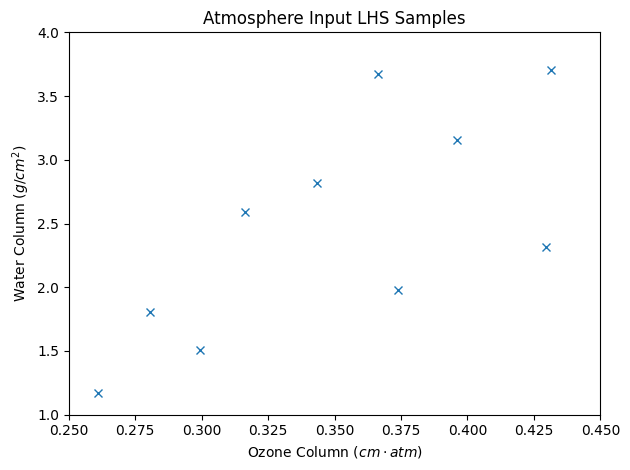

In [4]:
fig, ax = plt.subplots()
ax.plot(ozone_samples, water_samples, "x")
ax.set_xlim(OZONE_RANGE)
ax.set_ylim(WATER_RANGE)
ax.set_xlabel("Ozone Column ($cm\cdot atm$)")
ax.set_ylabel("Water Column ($g/cm^2$)")
ax.set_title("Atmosphere Input LHS Samples")
fig.tight_layout()

## Perform simulation

In [5]:
sweep = SweepSimulation(
    {
        "lhs": {
            "atmosphere.ozone": ozone_samples,
            "atmosphere.water": water_samples,
        },
        "wavelength.value": WAVELENGTHS,
    },
    base=pysixs_default_inputs().replace(
        atmosphere=rtm_param.AtmosphereWaterOzone(),
    ),
)

engine = PySixSEngine()
runner = ConcurrentExecutor(max_workers=16)

with alive_progress.alive_bar(sweep.sweep_size, force_tty=True) as bar:
    runner.run(sweep, engine, step_callback=lambda _: bar())

train_results = runner.collect_results()
train_output = train_results.apparent_radiance

display(train_results)

|████████████████████████████████████████| 40/40 [100%] in 0.4s (71.62/s)       


<xarray.Dataset>
Dimensions:                        (lhs: 10, wavelength.value: 4)
Coordinates:
  * lhs                            (lhs) int64 0 1 2 3 4 5 6 7 8 9
    atmosphere.ozone               (lhs) float64 0.3433 0.2807 ... 0.3664 0.3961
    atmosphere.water               (lhs) float64 2.822 1.803 ... 3.676 3.159
  * wavelength.value               (wavelength.value) float64 0.57 ... 0.6475
Data variables:
    transmittance_scattering_down  (lhs, wavelength.value) float64 0.893 ... ...
    transmittance_diffuse_down     (lhs, wavelength.value) float64 0.3883 ......
    transmittance_diffuse_up       (lhs, wavelength.value) float64 0.4674 ......
    transmittance_direct_up        (lhs, wavelength.value) float64 0.5326 ......
    transmittance_scattering_up    (lhs, wavelength.value) float64 1.0 ... 1.0
    apparent_radiance              (lhs, wavelength.value) float64 126.5 ... ...
    transmittance_direct_down      (lhs, wavelength.value) float64 0.5047 ......
Attributes:
    version:     0.2.0.dev0+4ab13f8
    platform:    CPython 3.10.12 (Linux atricapillus 6.2.0-26-generic #26~22....
    engine:      rtm_wrapper.engines.sixs.PySixSEngine
    base_repr:   Inputs(wavelength=WavelengthFixed(value=0.5), atmosphere=Atm...
    base_pzb64:  H4sIAN245GQC/2VRzUoDMRBW0FpoQRERH0FBevEBpBeroFgE6THMdmc3gfws...
    sim_start:   2023-08-22T09:32:12.752158-04:00
    sim_end:     2023-08-22T09:32:13.155254-04:00

## Plot scatter of outputs at each input

Text(0.02, 0.5, 'Water Column ($g/cm^2$)')

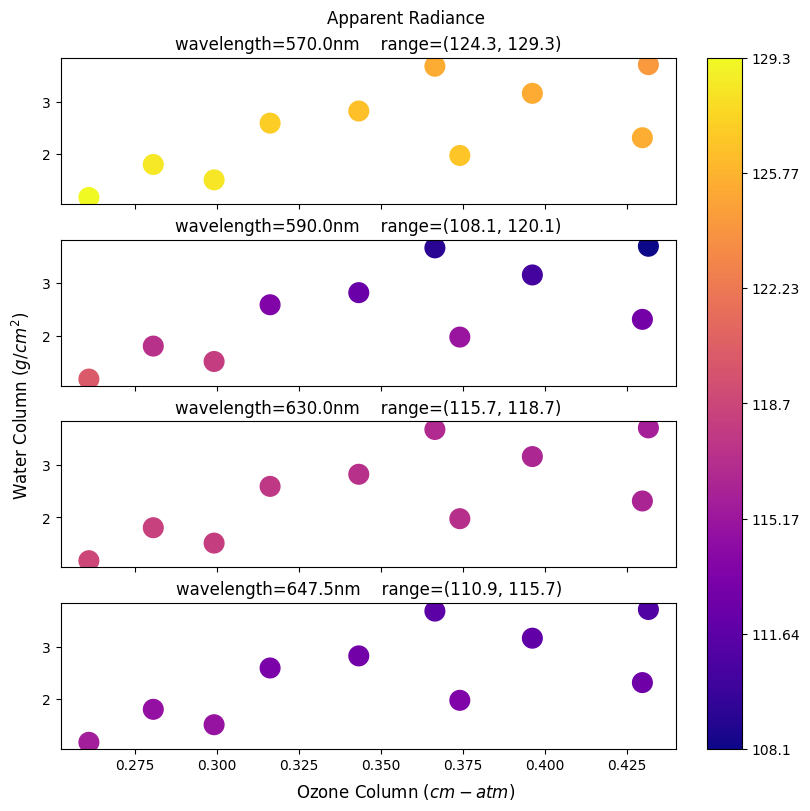

In [6]:
# Rescale outputs to [0,1] to use as colormap indices.
color_source = train_output.values
color = (color_source - color_source.min()) / (color_source.max() - color_source.min())

fig, axs = plt.subplots(
    nrows=len(WAVELENGTHS),
    layout="constrained",
    sharey="all",
    sharex="all",
    figsize=(8, 8),
)
for idx, (wavelength, ax) in enumerate(zip(WAVELENGTHS, axs.flat)):
    art = ax.scatter(
        train_results.coords["atmosphere.ozone"].values,
        train_results.coords["atmosphere.water"].values,
        c=color[:, idx],
        s=200,
        cmap="plasma",
        vmin=0,
        vmax=1,
    )
    ax.set_title(
        f"wavelength={wavelength*1000:.1f}nm"
        f"    range=({color_source[:, idx].min():.1f}, {color_source[:, idx].max():.1f})"
    )


n_ticks = 7
cbar = fig.colorbar(art, ax=axs.flat, ticks=np.linspace(0, 1, n_ticks))
cbar.ax.set_yticklabels(
    np.round(np.linspace(color_source.min(), color_source.max(), n_ticks), 2)
)
fig.suptitle("Apparent Radiance")
fig.supxlabel("Ozone Column ($cm-atm$)")
fig.supylabel("Water Column ($g/cm^2$)")

# Train Emulator

## Extract training arrays

In [7]:
x_train = np.stack(
    [
        train_results.coords["atmosphere.ozone"].values,
        train_results.coords["atmosphere.water"].values,
    ],
    axis=-1,
)
y_train = np.stack(
    [
        train_output.isel({"wavelength.value": idx}).values.reshape(-1, 1)
        for idx in range(len(WAVELENGTHS))
    ],
    axis=0,
)

print(f"{x_train.shape=}, {y_train.shape=}")

x_train.shape=(10, 2), y_train.shape=(4, 10, 1)


## Create GP model

In [8]:
kernel = 1.0 * skl_gp.kernels.RBF()  # + sklearn_gp.kernels.WhiteKernel()
gaussian_process = skl_gp.GaussianProcessRegressor(
    kernel=kernel, n_restarts_optimizer=30, alpha=1e-1
)

pipeline = sklearn.pipeline.Pipeline(
    [("scale", skl_pre.StandardScaler(with_std=False)), ("gp", gaussian_process)]
)
display(pipeline)
display(pipeline.named_steps["gp"].kernel.hyperparameters)

models = [skl_base.clone(pipeline) for _ in range(len(WAVELENGTHS))]

Pipeline(steps=[('scale', StandardScaler(with_std=False)),
                ('gp',
                 GaussianProcessRegressor(alpha=0.1,
                                          kernel=1**2 * RBF(length_scale=1),
                                          n_restarts_optimizer=30))])

[Hyperparameter(name='k1__constant_value', value_type='numeric', bounds=array([[1.e-05, 1.e+05]]), n_elements=1, fixed=False),
 Hyperparameter(name='k2__length_scale', value_type='numeric', bounds=array([[1.e-05, 1.e+05]]), n_elements=1, fixed=False)]

## Fit model

In [9]:
for target, m, wl in zip(y_train, models, WAVELENGTHS):
    m.fit(x_train, target)
    print(f"{wl*1000:.1f}: {m.named_steps['gp'].kernel_}")

570.0: 257**2 * RBF(length_scale=28.7)
590.0: 189**2 * RBF(length_scale=19.4)
630.0: 199**2 * RBF(length_scale=29.3)
647.5: 162**2 * RBF(length_scale=33.2)


## Plot marginal likelihood surface

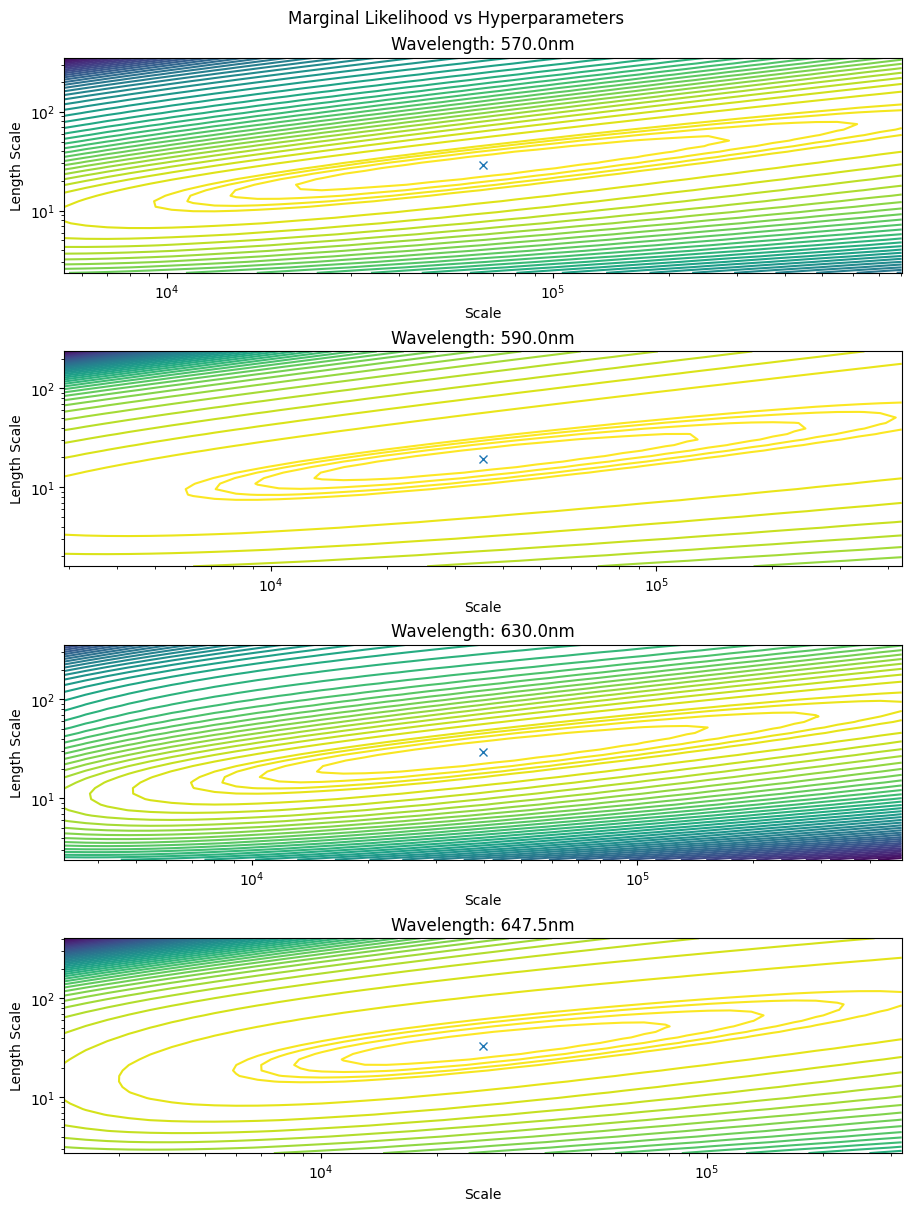

In [10]:
fig, axs = plt.subplots(nrows=len(WAVELENGTHS), figsize=(9, 12), layout="constrained")

for ax, wl, model in zip(axs.flat, WAVELENGTHS, models):
    gp = model.named_steps["gp"]
    fit_theta = gp.kernel_.theta

    # Range of hyperparameter to compute marginal likelihood over.
    # Log scaled, and centered about fit hyperparameter values found above.
    log_scale_range = np.linspace(-2.5, 2.5, 40) + fit_theta[0]
    log_length_range = np.linspace(-2.5, 2.5, 40) + fit_theta[1]

    mesh_scale, mesh_length = np.meshgrid(log_scale_range, log_length_range)
    # Preallocate array for likelihood at each hyperparameter combination.
    log_marginal_likelihoods = np.zeros(mesh_scale.shape)

    for scale, length, out in np.nditer(
        [mesh_scale, mesh_length, log_marginal_likelihoods],
        op_flags=[["readonly"], ["readonly"], ["writeonly"]],
    ):
        theta = [scale, length]
        out[...] = gp.log_marginal_likelihood(theta)

    ax.set_xscale("log")
    ax.set_yscale("log")
    # Pick contour levels. Increase level density near max to better show peaks.
    peak_switch = np.percentile(log_marginal_likelihoods, 85)
    levels = np.hstack(
        (
            np.linspace(log_marginal_likelihoods.min(), peak_switch, 40)[:-1],
            np.linspace(peak_switch, log_marginal_likelihoods.max(), 5),
        )
    )
    # levels = 30
    ax.contour(
        np.exp(mesh_scale), np.exp(mesh_length), log_marginal_likelihoods, levels
    )
    ax.plot(*np.exp(fit_theta), "x")
    ax.set_xlabel("Scale")
    ax.set_ylabel("Length Scale")
    ax.set_title(f"Wavelength: {wl*1000:0.1f}nm")

fig.suptitle("Marginal Likelihood vs Hyperparameters");

# Asses Emulator

## Generate test data

In [11]:
ozone_test = np.linspace(*OZONE_RANGE, 30)
water_test = np.linspace(*WATER_RANGE, 31)

## Obtain actual sim results for test data

In [12]:
sweep = SweepSimulation(
    {
        "wavelength.value": WAVELENGTHS,
        "atmosphere.ozone": ozone_test,
        "atmosphere.water": water_test,
    },
    base=pysixs_default_inputs().replace(
        atmosphere=rtm_param.AtmosphereWaterOzone(),
    ),
)

engine = PySixSEngine()
runner = ConcurrentExecutor(max_workers=16)
with alive_progress.alive_bar(sweep.sweep_size, force_tty=True) as bar:
    runner.run(sweep, engine, step_callback=lambda _: bar())

test_results = runner.collect_results()
test_output = test_results.apparent_radiance

display(test_output)

|████████████████████████████████████████| 3720/3720 [100%] in 34.4s (108.35/s) 


<xarray.DataArray 'apparent_radiance' (wavelength.value: 4,
                                       atmosphere.ozone: 30,
                                       atmosphere.water: 31)>
array([[[129.648, 129.559, 129.47 , ..., 127.26 , 127.178, 127.097],
        [129.527, 129.438, 129.349, ..., 127.141, 127.06 , 126.979],
        [129.406, 129.317, 129.229, ..., 127.023, 126.941, 126.86 ],
        ...,
        [126.427, 126.34 , 126.253, ..., 124.098, 124.019, 123.939],
        [126.309, 126.222, 126.136, ..., 123.983, 123.903, 123.824],
        [126.191, 126.105, 126.018, ..., 123.867, 123.788, 123.709]],

       [[121.073, 120.612, 120.158, ..., 110.408, 110.095, 109.784],
        [120.964, 120.503, 120.05 , ..., 110.309, 109.995, 109.685],
        [120.855, 120.394, 119.941, ..., 110.209, 109.896, 109.586],
        ...,
        [118.154, 117.704, 117.261, ..., 107.746, 107.44 , 107.138],
        [118.048, 117.598, 117.155, ..., 107.649, 107.343, 107.041],
        [117.941, 117.491, 117.049, ..., 107.552, 107.246, 106.944]],

       [[118.926, 118.893, 118.86 , ..., 118.059, 118.03 , 118.002],
        [118.834, 118.801, 118.769, ..., 117.969, 117.94 , 117.911],
        [118.743, 118.71 , 118.677, ..., 117.878, 117.849, 117.82 ],
        ...,
        [116.483, 116.451, 116.419, ..., 115.635, 115.606, 115.578],
        [116.394, 116.361, 116.329, ..., 115.546, 115.517, 115.489],
        [116.304, 116.272, 116.24 , ..., 115.457, 115.429, 115.401]],

       [[116.066, 115.919, 115.775, ..., 112.436, 112.322, 112.208],
        [116.002, 115.856, 115.711, ..., 112.374, 112.26 , 112.146],
        [115.938, 115.792, 115.647, ..., 112.313, 112.198, 112.084],
        ...,
        [114.353, 114.209, 114.066, ..., 110.777, 110.664, 110.552],
        [114.29 , 114.146, 114.003, ..., 110.716, 110.603, 110.491],
        [114.227, 114.083, 113.941, ..., 110.655, 110.542, 110.43 ]]])
Coordinates:
  * wavelength.value  (wavelength.value) float64 0.57 0.59 0.63 0.6475
  * atmosphere.ozone  (atmosphere.ozone) float64 0.25 0.2569 ... 0.4431 0.45
  * atmosphere.water  (atmosphere.water) float64 1.0 1.1 1.2 1.3 ... 3.8 3.9 4.0
Attributes:
    title:    Apparent Radiance
    unit:     W/sr-m^2

## Extract test arrays

In [13]:
mesh_ozone, mesh_water = np.meshgrid(
    test_results.coords["atmosphere.ozone"].values,
    test_results.coords["atmosphere.water"].values,
    indexing="ij",
)

x_test = np.hstack((mesh_ozone.reshape(-1, 1), mesh_water.reshape(-1, 1)))
y_test = test_output.values.reshape(len(WAVELENGTHS), -1, 1)
print(f"{x_test.shape=}, {y_test.shape=}")

x_test.shape=(930, 2), y_test.shape=(4, 930, 1)


## Evaluate model on test data

In [14]:
pred_means = np.empty((len(WAVELENGTHS), *mesh_ozone.shape))
pred_stds = np.empty((len(WAVELENGTHS), *mesh_ozone.shape))

for idx, model in enumerate(models):
    mean, std = model.predict(x_test, return_std=True)
    pred_means[idx, ...] = mean.reshape(mesh_ozone.shape)
    pred_stds[idx, ...] = std.reshape(mesh_ozone.shape)

y_test_shaped = y_test.reshape(len(WAVELENGTHS), *mesh_ozone.shape)
pred_error = pred_means - y_test_shaped

## Compute metrics

In [15]:
rmse = np.sqrt(np.mean(pred_error**2))

abs_error = np.abs(pred_error)

print(f"RMSE: {rmse:0.2f}")
print(f"Avg abs err: {np.mean(abs_error):0.2f}")
print(f"Max abs err: {np.max(abs_error):0.2f}")
print(f"Avg rel err: {np.mean(abs_error/y_test_shaped):0.2%}")
print(f"Max rel err: {np.max(abs_error/y_test_shaped):0.2%}")

RMSE: 0.10
Avg abs err: 0.08
Max abs err: 0.35
Avg rel err: 0.07%
Max rel err: 0.31%


## Plot posterior mean, std, error

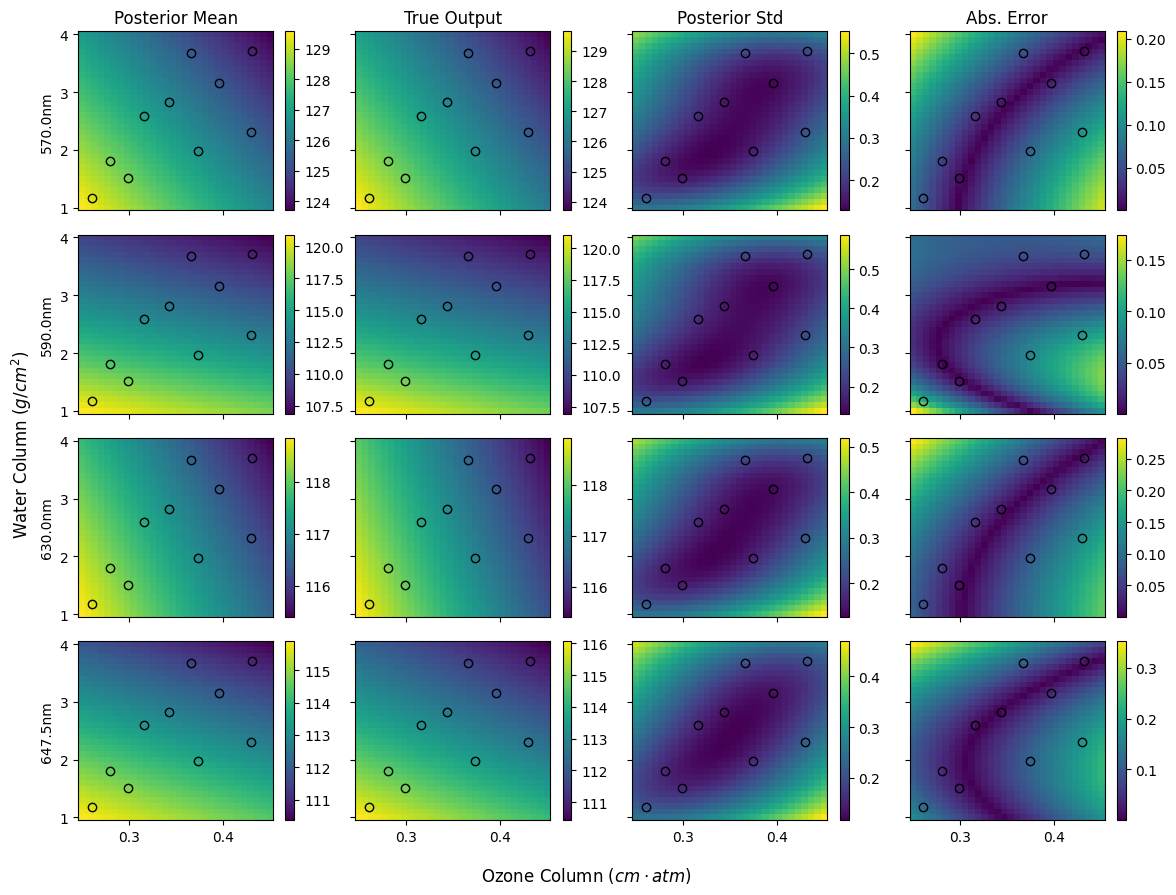

In [16]:
fig, axs = plt.subplots(
    nrows=len(WAVELENGTHS), ncols=4, figsize=(12, 9), sharex="all", sharey="all"
)

for idx, (ax_row, wavelength) in enumerate(zip(axs, WAVELENGTHS)):
    ax_row[0].set_ylabel(f"{wavelength*1e3:0.1f}nm")
    # Plot predicted mean surface.
    ax = ax_row[0]
    art = ax.pcolormesh(mesh_ozone, mesh_water, pred_means[idx, ...])
    ax.plot(
        train_results.coords["atmosphere.ozone"].values,
        train_results.coords["atmosphere.water"].values,
        "o",
        color="k",
        markerfacecolor="none",
    )
    cbar = fig.colorbar(art)

    # Plot true output surface.
    ax = ax_row[1]
    art = ax.pcolormesh(mesh_ozone, mesh_water, y_test_shaped[idx, ...])
    ax.plot(
        train_results.coords["atmosphere.ozone"].values,
        train_results.coords["atmosphere.water"].values,
        "o",
        color="k",
        markerfacecolor="none",
    )
    fig.colorbar(art)

    # Plot predicted variance surface.
    ax = ax_row[2]
    art = ax.pcolormesh(mesh_ozone, mesh_water, pred_stds[idx, ...])
    ax.plot(
        train_results.coords["atmosphere.ozone"].values,
        train_results.coords["atmosphere.water"].values,
        "o",
        color="k",
        markerfacecolor="none",
    )
    fig.colorbar(art)

    # Plot error surface.
    ax = ax_row[3]
    art = ax.pcolormesh(mesh_ozone, mesh_water, np.abs(pred_error[idx, ...]))
    ax.plot(
        train_results.coords["atmosphere.ozone"].values,
        train_results.coords["atmosphere.water"].values,
        "o",
        color="k",
        markerfacecolor="none",
    )
    fig.colorbar(art)

axs[0, 0].set_title("Posterior Mean")
axs[0, 1].set_title("True Output")
axs[0, 2].set_title("Posterior Std")
axs[0, 3].set_title("Abs. Error")

fig.supxlabel("Ozone Column ($cm\cdot atm$)")
fig.supylabel("Water Column ($g/cm^2$)")
fig.tight_layout()